In [1]:
from google.colab import drive
import os
import random
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

drive.mount('/content/drive')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)
print(">>> 환경 설정 및 시드 고정 완료.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f">>> 사용 디바이스: {device}")

Mounted at /content/drive
>>> 환경 설정 및 시드 고정 완료.
>>> 사용 디바이스: cuda


In [2]:
class MultiHeadModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)

        # Head 1: 관련도 (Binary: 0 or 1)
        self.rel_classifier = nn.Linear(768, 2)
        # Head 2: 중요도 (Multi-class: 0, 1, 2)
        self.imp_classifier = nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        if isinstance(outputs, tuple):
            last_hidden_state = outputs[0]
        else:
            last_hidden_state = outputs.last_hidden_state

        cls_output = last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)

        rel_logits = self.rel_classifier(cls_output)
        imp_logits = self.imp_classifier(cls_output)

        return rel_logits, imp_logits

print(">>> 모델 클래스 재정의 완료")

>>> 모델 클래스 재정의 완료


In [3]:
# 경로 설정 (사용자 지정 경로)
MODEL_SAVE_PATH = '/content/drive/MyDrive/assignment5/saved_model_v5'

MODEL_NAME = 'klue/roberta-small'

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 모델 초기화
model = MultiHeadModel(MODEL_NAME)

# 가중치 파일 찾기
weights_path = os.path.join(MODEL_SAVE_PATH, 'pytorch_model.bin')

if not os.path.exists(weights_path):
    print(f"Warning: {weights_path} 경로에 파일이 없습니다. 폴더 내 파일을 확인합니다.")
    files = os.listdir(MODEL_SAVE_PATH)
    print(f"폴더 내 파일 목록: {files}")
    for f in files:
        if f.endswith('.bin') or f.endswith('.pt') or f.endswith('.pth'):
            weights_path = os.path.join(MODEL_SAVE_PATH, f)
            break

try:
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f">>> 모델 가중치 로드 성공: {weights_path}")
    print(f">>> 사용된 모델 베이스: {MODEL_NAME}")
except Exception as e:
    print(f">>> 모델 로드 실패: {e}")
    print("TIP: 만약 여전히 에러가 난다면, 학습 코드(training.ipynb)에서 사용한 'model_name'이 무엇이었는지 확인해주세요.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> 모델 가중치 로드 성공: /content/drive/MyDrive/assignment5/saved_model_v5/pytorch_model.bin
>>> 사용된 모델 베이스: klue/roberta-small


In [4]:
# label_relevance, label_importance, eval_category(출처)
examples = [
    {
        "title": "HUFS 인문학xAI 특강 안내",
        "content": "HUFS 도서관에서 인문학xAI 특강이 열리니 재학생 여러분의 많은 관심 부탁드립니다. 강연 주제: 인문학에도 AI를 적용할 수 있을까? 강연자: 최승택 교수님. 장소: 도서관 1층 스마트플라자. 시간: 12월 3일 수요일 15:00~13:30.",
        "label_relevance": 1,
        "label_importance": 1,
        "eval_category": "공지(일반)"
    },
    {
        "title": "학교 서버 다운으로 인한 겨울학기 수강신청 일정 변경 안내",
        "content": "학교 수강신청 서버가 다운되어 겨울학기 수강신청 일자가 변경되었음을 안내합니다. 기존: 2025년 11월 25일~27일 10:00~15:00, 변경 후: 2025년 12월 2일 ~4일 10:00~15:00. 겨울학기 수강을 원하는 학생들은 변경된 일정을 숙지하여 주시기 바랍니다.",
        "label_relevance": 1,
        "label_importance": 2,
        "eval_category": "학사"
    },
    {
        "title": "외대외대 장학금 신청 안내",
        "content": "외대외대 장학금 신청을 안내하오니 관심 있는 학생들은 HUFS Ability를 통해 신청서를 제출해 주시기 바랍니다. 장학금명: 외대외대 장학금, 대상: 본교 서울캠퍼스 2학년 재학생, 선발 조건: 학업에 열의가 있고 품행이 단정한 학생. 본 장학금은 등록금성 장학금으로 등록금을 초과하여 수혜가 불가능합니다. 신청 서류: 자기소개서, 개인정보동의서, 성적증명서, 자기소개서에 기재한 내용의 증빙서류",
        "label_relevance": 1,
        "label_importance": 0,
        "eval_category": "장학"
    },
    {
        "title": "HHUUFFSS기업 채용연계형 인턴 모집 안내",
        "content": "우리 학과와 채용연계형 인턴 채용 계약은 맺은 HHUUFFSS기업의 인턴 모집 공고입니다. 학생들의 많은 관심 부탁드립니다. 모집 대상: 2026년 1학기 기준 국제통상학과 4학년 재학생, 제출 서류: 첨부파일 참고, 직무: 해외영업, 업무: 해외 시장 발굴과 해외 수출 동향 분석, 우대 사항: 영어 능통자, 관련 자격증 소지자, 해외영업 업무 유경험자, 지원 기간: 2026년 1월 22일 9시~1월 31일 17시",
        "label_relevance": 1,
        "label_importance": 0,
        "eval_category": "IEL" # 원본 데이터셋에는 없는 카테고리일 수 있으나 테스트용으로 사용
    },
    {
        "title": "자연어 처리 실무 특강 안내",
        "content": "한국외국어대학교 AI융합대학과 HHUUFFSS기업이 공동 주관하는 자연어처리 실무 특강 신청 안내입니다. 내용: 1차:자연어 처리를 실제 업무에 적용하는 방법, 2차: 코딩테스트 통과 비법, 날짜: 1차: 2026년 1월 9~10일, 신청: qr코드를 통한 신청.",
        "label_relevance": 1,
        "label_importance": 1,
        "eval_category": "LAI"
    }
]

inference_df = pd.DataFrame(examples)
print(f">>> 추론용 데이터 준비 완료: {len(inference_df)}건")

>>> 추론용 데이터 준비 완료: 5건


In [5]:
def predict_inference(model, tokenizer, df):
    model.eval()
    preds_rel = []
    preds_imp = []

    print(">>> 추론 시작...")
    with torch.no_grad():
        for idx, row in df.iterrows():
            text = str(row['title']) + " " + str(row['content'])

            encoding = tokenizer(
                text,
                return_tensors='pt',
                max_length=256,
                padding='max_length',
                truncation=True
            )

            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # 모델 예측
            rel_logits, imp_logits = model(input_ids, attention_mask)

            # 결과 변환
            pred_rel = torch.argmax(rel_logits, dim=1).item()
            pred_imp = torch.argmax(imp_logits, dim=1).item()

            preds_rel.append(pred_rel)
            preds_imp.append(pred_imp)

    df['pred_rel'] = preds_rel
    df['pred_imp'] = preds_imp
    print(">>> 추론 완료.")
    return df

result_df = predict_inference(model, tokenizer, inference_df)

>>> 추론 시작...
>>> 추론 완료.



   [1] 전체 추론 결과 요약


,eval_category,title,label_relevance,pred_rel,Rel_OX,label_importance,pred_imp,Imp_OX
0,공지(일반),HUFS 인문학xAI 특강 안내,1,1,O,1,1,O
1,학사,학교 서버 다운으로 인한 겨울학기 수강신청 일정 변경 안내,1,1,O,2,2,O
2,장학,외대외대 장학금 신청 안내,1,1,O,0,0,O
3,IEL,HHUUFFSS기업 채용연계형 인턴 모집 안내,1,1,O,0,0,O
4,LAI,자연어 처리 실무 특강 안내,1,1,O,1,1,O



   [2] Confusion Matrix


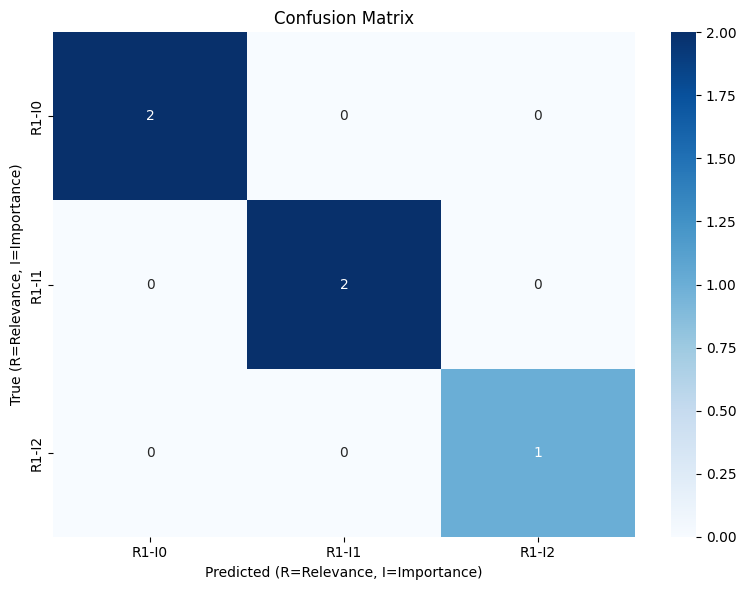

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import pandas as pd
import warnings


warnings.filterwarnings('ignore')

result_df['Rel_OX'] = result_df.apply(lambda x: 'O' if x['label_relevance'] == x['pred_rel'] else 'X', axis=1)
result_df['Imp_OX'] = result_df.apply(lambda x: 'O' if x['label_importance'] == x['pred_imp'] else 'X', axis=1)

# 관련도와 중요도를 결합한 통합 라벨 생성
def get_combined_label(r, i):
    return f"R{r}-I{i}"

result_df['true_comb'] = result_df.apply(lambda x: get_combined_label(x['label_relevance'], x['label_importance']), axis=1)
result_df['pred_comb'] = result_df.apply(lambda x: get_combined_label(x['pred_rel'], x['pred_imp']), axis=1)

# 출력 1: 전체 추론 결과 요약 표
print("\n" + "="*80)
print("   [1] 전체 추론 결과 요약")
print("="*80)

display_cols = [
    'eval_category', 'title',
    'label_relevance', 'pred_rel', 'Rel_OX',
    'label_importance', 'pred_imp', 'Imp_OX'
]

from IPython.display import display
display(result_df[display_cols])

# 출력 2: 통합 Confusion Matrix
print("\n" + "="*80)
print("   [2] Confusion Matrix")
print("="*80)

def plot_integrated_cm(df):
    plt.figure(figsize=(8, 6))

    all_labels = sorted(list(set(df['true_comb'].unique()) | set(df['pred_comb'].unique())))

    cm = confusion_matrix(df['true_comb'], df['pred_comb'], labels=all_labels)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted (R=Relevance, I=Importance)')
    plt.ylabel('True (R=Relevance, I=Importance)')
    plt.tight_layout()
    plt.show()

plot_integrated_cm(result_df)
